# Importing the necessary libraries

In [232]:
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns 
import matplotlib.pyplot as plt
import missingno
from collections import  Counter
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Import the data to process it

We import the training data and the test data, we will only be working with the training data. Ultimately, we will make the predictions about the test data

In [233]:
# concatenating the training and the testing data so we have more values to work with and therefor we can better approximate the missing values
# the combined data differentiates the training set and the test set by encoding them with 1 and 0 respectively
training = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
training['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN
all_data = pd.concat([training,test])

%matplotlib inline
all_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'],
      dtype='object')

In [234]:
all_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


# 1. Data analysis 


### 1.3. Data Preprocessing


#### Remove null value 
we need to decide what we arte goig to do here

In [235]:
#replace missing age  with 0 , potentially with mean 
all_data['Age'].fillna(all_data['Age'].median(), inplace = True)

#complete embarked with mode
all_data['Embarked'].fillna(all_data['Embarked'].mode()[0], inplace = True)

#complete missing fare with median
all_data['Fare'].fillna(all_data['Fare'].median(), inplace = True)

#### Remove outliers
We need to handle the misssing values in all the columns
Ensure the data only includes the relevent variables. 

In [236]:
# plagiarised

def detect_outliers(df, n, features):
    """"
    This function will loop through a list of features and detect outliers in each one of those features. In each
    loop, a data point is deemed an outlier if it is less than the first quartile minus the outlier step or exceeds
    third quartile plus the outlier step. The outlier step is defined as 1.5 times the interquartile range. Once the 
    outliers have been determined for one feature, their indices will be stored in a list before proceeding to the next
    feature and the process repeats until the very last feature is completed. Finally, using the list with outlier 
    indices, we will count the frequencies of the index numbers and return them if their frequency exceeds n times.    
    """
    outlier_indices = [] 
    for col in features: 
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR 
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col) 
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n) 
    return multiple_outliers

outliers_to_drop = detect_outliers(all_data, 2, ['Age', 'SibSp', 'Parch', 'Fare']) 
print("We will drop these {} indices: ".format(len(outliers_to_drop)), outliers_to_drop)
all_data.loc[outliers_to_drop, :]


We will drop these 50 indices:  [7, 16, 96, 119, 164, 268, 297, 305, 386, 438, 587, 642, 659, 745, 824, 879, 69, 142, 179, 201, 217, 307, 308, 314, 343, 24, 27, 59, 88, 159, 180, 324, 341, 374, 409, 792, 846, 863, 53, 140, 188, 360, 394, 118, 184, 262, 390, 407, 218, 306]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,1
7,899,NaN,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,0
16,17,0.0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.1250,NaN,Q,1
16,908,NaN,2,"Keane, Mr. Daniel",male,35.0,0,0,233734,12.3500,NaN,Q,0
96,97,0.0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,1299,NaN,1,"Widener, Mr. George Dunton",male,50.0,1,1,113503,211.5000,C80,C,0
218,219,1.0,1,"Bazzani, Miss. Albina",female,32.0,0,0,11813,76.2917,D15,C,1
218,1110,NaN,1,"Widener, Mrs. George Dunton (Eleanor Elkins)",female,50.0,1,1,113503,211.5000,C80,C,0
306,307,1.0,1,"Fleming, Miss. Margaret",female,28.0,0,0,17421,110.8833,NaN,C,1


### 1.2 Feature engineering
The data for the cabin and tickes has many classes and is very messy therefore we will try clean it up by leveraging these classes to create new variables that aren't in the training set, Furthermore we will look at if the persons title is related to that persons survival

#### Title data

In [237]:
training.Name.head()
# splits up the data into the persons title 
all_data['Title'] = training.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
all_data['Title'].value_counts()
#only using titles that aoear more than 10 times 
stat_min = 10 #while small is arbitrary, we'll use the common minimum in statistics: http://nicholasjjackson.com/2012/03/08/sample-size-is-10-a-magic-number/
title_names = (all_data['Title'].value_counts() < stat_min) #this will create a true false series with title name as index

#apply and lambda functions are quick and dirty code to find and replace with fewer lines of code: https://community.modeanalytics.com/python/tutorial/pandas-groupby-and-python-lambda-functions/
all_data['Title'] = all_data['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(all_data['Title'].value_counts())

Mr        745
Miss      283
Mrs       183
Master     63
Misc       25
Dr         10
Name: Title, dtype: int64


#### Family Size

In [238]:
# feature engineering 
all_data['FamilySize']=all_data['Parch']+all_data['SibSp']+1
all_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test,Title,FamilySize
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,Mr,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs,2
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Mrs,2
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,Mr,1


#### isAlone

In [239]:
all_data['IsAlone'] = 1 #initialize to yes/1 is alone
all_data['IsAlone'].loc[all_data['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1

c:\Users\shell\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


#### Fare

In [240]:
all_data['FareBin'] = pd.qcut(all_data['Fare'], 4)

#### Age

In [241]:
#Age Bins/Buckets using cut or value bins: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html
all_data['AgeBin'] = pd.cut(all_data['Age'].astype(int), 5)

#### Encoding

In [242]:
#CONVERT: convert objects to category using Label Encoder for train and test/validation dataset
#code categorical data
label = LabelEncoder() 
all_data['Sex_Code'] = label.fit_transform(all_data['Sex'])
all_data['Embarked_Code'] = label.fit_transform(all_data['Embarked'])
all_data['Title_Code'] = label.fit_transform(all_data['Title'])
all_data['AgeBin_Code'] = label.fit_transform(all_data['AgeBin'])
all_data['FareBin_Code'] = label.fit_transform(all_data['FareBin'])

#### Dropping columns

In [243]:
drop_column = ['PassengerId','Cabin', 'Ticket','Name','Age','Sex','Fare','Embarked','SibSp','Parch','FareBin','AgeBin','Title']
all_data.drop(drop_column, axis=1, inplace = True)

In [244]:
all_data.head(20)

,Survived,Pclass,train_test,FamilySize,IsAlone,Sex_Code,Embarked_Code,Title_Code,AgeBin_Code,FareBin_Code
0,0.0,3,1,2,0,1,2,4,1,0
1,1.0,1,1,2,0,0,0,5,2,3
2,1.0,3,1,1,1,0,2,3,1,1
3,1.0,1,1,2,0,0,2,5,2,3
4,0.0,3,1,1,1,1,2,4,2,1
5,0.0,3,1,1,1,1,1,4,1,1
6,0.0,1,1,1,1,1,2,4,3,3
7,0.0,3,1,5,0,1,2,1,0,2
8,1.0,3,1,3,0,0,2,5,1,1
9,1.0,2,1,2,0,0,0,5,0,2


## Modeling

#### Splitting up data

In [245]:
x_train = all_data[all_data.train_test == 1].drop(['train_test'], axis =1)
x_test = all_data[all_data.train_test == 0].drop(['train_test'], axis =1)
print(x_test.shape)
x_test = x_test.drop(['Survived'], axis =1)
y_train = all_data[all_data.train_test==1].Survived

(418, 9)


#### Training

In [246]:
x_test.head()
print(x_test.shape)


(418, 8)


## Model Building (Baseline Validation Performance)
Before going further, I like to see how various different models perform with default parameters. I tried the following models using 5 fold cross validation to get a baseline. With a validation set basline, we can see how much tuning improves each of the models. Just because a model has a high basline on this validation set doesn't mean that it will actually do better on the eventual test set. 

- Naive Bayes (72.6%)
- Logistic Regression (82.1%)
- Decision Tree (77.6%)
- K Nearest Neighbor (80.5%)
- Random Forest (80.6%)
- **Support Vector Classifier (83.2%)**
- Xtreme Gradient Boosting (81.8%)
- Soft Voting Classifier - All Models (82.8%)

In [247]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [248]:
#I usually use Naive Bayes as a baseline for my classification tasks 
gnb = GaussianNB()
cv = cross_val_score(gnb,x_train,y_train,cv=5)
print(cv)
print(cv.mean())

[1. 1. 1. 1. 1.]
1.0


In [249]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,x_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.93854749 0.94382022 0.95505618 0.94382022 0.9494382 ]
0.9461364634988387


In [250]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,x_train,y_train,cv=5)
print(cv)
print(cv.mean())

[1. 1. 1. 1. 1.]
1.0


In [251]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,x_train,y_train,cv=5)
print(cv)
print(cv.mean())

[1. 1. 1. 1. 1.]
1.0


In [252]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,x_train,y_train,cv=5)
print(cv)
print(cv.mean())

[1. 1. 1. 1. 1.]
1.0


In [253]:
svc = SVC(probability = True)
cv = cross_val_score(svc,x_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.98882682 0.98876404 1.         1.         1.        ]
0.9955181721172558


In [254]:
#Voting classifier takes all of the inputs and averages the results. For a "hard" voting classifier each classifier gets 1 vote "yes" or "no" and the result is just a popular vote. For this, you generally want odd numbers
#A "soft" classifier averages the confidence of each of the models. If a the average confidence is > 50% that it is a 1 it will be counted as such
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('svc',svc)], voting = 'soft') 

In [255]:
cv = cross_val_score(voting_clf,x_train,y_train,cv=5)
print(cv)
print(cv.mean())

[1. 1. 1. 1. 1.]
1.0


In [256]:
print(x_test.isna().sum().sum())
print(x_test.shape)
print(x_train.shape)

voting_clf.fit(x_train,y_train)
y_hat_base_vc = voting_clf.predict(x_test).astype(int)
basic_submission = {'PassengerId': test.PassengerId, 'Survived': y_hat_base_vc}

base_submission = pd.DataFrame(data=basic_submission)
base_submission.to_csv('base_submission.csv', index=False)

0
(418, 8)
(891, 9)


ValueError: X has 8 features per sample; expecting 9

## Model Tuned Performance 
After getting the baselines, let's see if we can improve on the indivdual model results!I mainly used grid search to tune the models. I also used Randomized Search for the Random Forest and XG boosted model to simplify testing time. 

|Model|Baseline|Tuned Performance|
|-----|--------|-----------------|
|Naive Bayes| 72.6%| NA|
|Logistic Regression| 82.1%| 82.6%|
|Decision Tree| 77.6%| NA|
|K Nearest Neighbor| 80.5%|83.0%|
|Random Forest| 80.6%| 83.6|
|Support Vector Classifier| 83.2%| 83.2%|
|Xtreme Gradient Boosting| 81.8%| 85.3%|


In [ ]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

In [ ]:
#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [ ]:
lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_train_scaled,y_train)
clf_performance(best_clf_lr,'Logistic Regression')

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    1.8s


Logistic Regression
Best Score: 0.8279375357074843
Best Parameters: {'C': 1.623776739188721, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.6s finished


In [ ]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X_train_scaled,y_train)
clf_performance(best_clf_knn,'KNN')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.8s


KNN
Best Score: 0.8279375357074843
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    2.1s finished


In [ ]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train_scaled,y_train)
clf_performance(best_clf_svc,'SVC')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed:  3.4min finished


SVC
Best Score: 0.8335555132355742
Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In [ ]:
#Because the total feature space is so large, I used a randomized search to narrow down the paramters for the model. I took the best model from this and did a more granular search 
"""
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [100,500,1000], 
                                  'bootstrap': [True,False],
                                  'max_depth': [3,5,10,20,50,75,100,None],
                                  'max_features': ['auto','sqrt'],
                                  'min_samples_leaf': [1,2,4,10],
                                  'min_samples_split': [2,5,10]}
                                  
clf_rf_rnd = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 100, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf_rnd = clf_rf_rnd.fit(X_train_scaled,y_train)
clf_performance(best_clf_rf_rnd,'Random Forest')"""

"\nrf = RandomForestClassifier(random_state = 1)\nparam_grid =  {'n_estimators': [100,500,1000], \n                                  'bootstrap': [True,False],\n                                  'max_depth': [3,5,10,20,50,75,100,None],\n                                  'max_features': ['auto','sqrt'],\n                                  'min_samples_leaf': [1,2,4,10],\n                                  'min_samples_split': [2,5,10]}\n                                  \nclf_rf_rnd = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 100, cv = 5, verbose = True, n_jobs = -1)\nbest_clf_rf_rnd = clf_rf_rnd.fit(X_train_scaled,y_train)\nclf_performance(best_clf_rf_rnd,'Random Forest')"

In [ ]:
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [400,450,500,550],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [15, 20, 25],
                                  'max_features': ['auto','sqrt', 10],
                                  'min_samples_leaf': [2,3],
                                  'min_samples_split': [2,3]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train_scaled,y_train)
clf_performance(best_clf_rf,'Random Forest')

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 12.2min finished


Random Forest
Best Score: 0.8358027042468101
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 15, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 550}


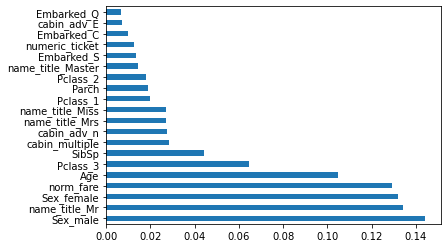

In [ ]:
best_rf = best_clf_rf.best_estimator_.fit(X_train_scaled,y_train)
feat_importances = pd.Series(best_rf.feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
"""xgb = XGBClassifier(random_state = 1)

param_grid = {
    'n_estimators': [20, 50, 100, 250, 500,1000],
    'colsample_bytree': [0.2, 0.5, 0.7, 0.8, 1],
    'max_depth': [2, 5, 10, 15, 20, 25, None],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 1.5, 2],
    'subsample': [0.5,0.6,0.7, 0.8, 0.9],
    'learning_rate':[.01,0.1,0.2,0.3,0.5, 0.7, 0.9],
    'gamma':[0,.01,.1,1,10,100],
    'min_child_weight':[0,.01,0.1,1,10,100],
    'sampling_method': ['uniform', 'gradient_based']
}

#clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
#best_clf_xgb = clf_xgb.fit(X_train_scaled,y_train)
#clf_performance(best_clf_xgb,'XGB')
clf_xgb_rnd = RandomizedSearchCV(xgb, param_distributions = param_grid, n_iter = 1000, cv = 5, verbose = True, n_jobs = -1)
best_clf_xgb_rnd = clf_xgb_rnd.fit(X_train_scaled,y_train)
clf_performance(best_clf_xgb_rnd,'XGB')"""

"xgb = XGBClassifier(random_state = 1)\n\nparam_grid = {\n    'n_estimators': [20, 50, 100, 250, 500,1000],\n    'colsample_bytree': [0.2, 0.5, 0.7, 0.8, 1],\n    'max_depth': [2, 5, 10, 15, 20, 25, None],\n    'reg_alpha': [0, 0.5, 1],\n    'reg_lambda': [1, 1.5, 2],\n    'subsample': [0.5,0.6,0.7, 0.8, 0.9],\n    'learning_rate':[.01,0.1,0.2,0.3,0.5, 0.7, 0.9],\n    'gamma':[0,.01,.1,1,10,100],\n    'min_child_weight':[0,.01,0.1,1,10,100],\n    'sampling_method': ['uniform', 'gradient_based']\n}\n\n#clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)\n#best_clf_xgb = clf_xgb.fit(X_train_scaled,y_train)\n#clf_performance(best_clf_xgb,'XGB')\nclf_xgb_rnd = RandomizedSearchCV(xgb, param_distributions = param_grid, n_iter = 1000, cv = 5, verbose = True, n_jobs = -1)\nbest_clf_xgb_rnd = clf_xgb_rnd.fit(X_train_scaled,y_train)\nclf_performance(best_clf_xgb_rnd,'XGB')"

In [ ]:
xgb = XGBClassifier(random_state = 1)

param_grid = {
    'n_estimators': [450,500,550],
    'colsample_bytree': [0.75,0.8,0.85],
    'max_depth': [None],
    'reg_alpha': [1],
    'reg_lambda': [2, 5, 10],
    'subsample': [0.55, 0.6, .65],
    'learning_rate':[0.5],
    'gamma':[.5,1,2],
    'min_child_weight':[0.01],
    'sampling_method': ['uniform']
}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_train_scaled,y_train)
clf_performance(best_clf_xgb,'XGB')


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed:  6.8min finished


XGB
Best Score: 0.8515266933282548
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.5, 'max_depth': None, 'min_child_weight': 0.01, 'n_estimators': 550, 'reg_alpha': 1, 'reg_lambda': 10, 'sampling_method': 'uniform', 'subsample': 0.65}


In [ ]:
y_hat_xgb = best_clf_xgb.best_estimator_.predict(X_test_scaled).astype(int)
xgb_submission = {'PassengerId': test.PassengerId, 'Survived': y_hat_xgb}
submission_xgb = pd.DataFrame(data=xgb_submission)
submission_xgb.to_csv('xgb_submission3.csv', index=False)